### Define tokenization of data

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

def tokenize_dataset(dataset: Dataset, model_checkpoint: str) -> Dataset:
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    train_data = dataset["train"]
    val_data = dataset["validation"]
    test_data = dataset["test"]

    train_data = train_data.map(tokenize_function, batched=True)
    # train_data = train_data.with_format("torch")

    val_data = val_data.map(tokenize_function, batched=True)
    # val_data = val_data.with_format("torch")

    test_data = test_data.map(tokenize_function, batched=True)
    # test_data = val_data.with_format("torch")

    return train_data, val_data, test_data

### Get tokenized datasets

In [43]:
from datasets import load_dataset

dataset = load_dataset("NTCAL/reviews_binary_not4_concat")
dataset = dataset.remove_columns(
    ["split", "review_id", "year", "category", "language", "title"])
dataset = dataset.rename_column("excerpt", "text")
dataset = dataset.rename_column("rating", "label")

model_checkpoint = ("ltgoslo/norbert2")
train_data, val_data, test_data = tokenize_dataset(dataset, model_checkpoint)

### Training arguments

In [ ]:
from transformers import TrainingArguments
from config import huggingface

default_args = {
    "output_dir": "./results",
    "overwrite_output_dir": True,
    "log_level": "error",
    "report_to": "none",
}

training_args = TrainingArguments(
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    gradient_accumulation_steps=8,
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=10,
    warmup_steps=1,                # number of warmup steps for learning rate scheduler
    gradient_checkpointing=True,
    optim="adafactor",
    save_strategy="epoch",
    learning_rate=2e-5,
    
    # load_best_model_at_end=True
    
    # hub_token=huggingface['hub_token'],
    # push_to_hub=True,
    # hub_model_id=huggingface['repo'],

    # fp8=True,
    # fp16=True,
    # bf16=True,
    # tf32=True,

    **default_args,
)

### Helper functions

In [ ]:
from sklearn.metrics import (accuracy_score, 
                             balanced_accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score)
import csv
import numpy as np
import pandas as pd
import tensorflow as tf

from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification


def pick_n_random_reviews(train_data: Dataset, n: int):
    random_indices = np.random.choice(
        list(range(0, len(train_data))), n, replace=False)
    random_reviews = train_data[random_indices]

    train_data = train_data.select(
        (
            i for i in range(len(train_data))
            if i not in set(random_indices)
        )
    )

    return train_data, random_reviews


def create_dataset_from_empty_df() -> Dataset:
    empty_df = pd.DataFrame(
        columns=['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])
    empty_df.reset_index(drop=True, inplace=True)
    empty_ds = Dataset.from_pandas(empty_df)

    return empty_ds


def add_samples_to_pool(train_pool: Dataset, new_reviews: dict) -> Dataset:
    list_of_reviews_dicts = [{'text': text, 'label': label, 'input_ids': input_ids, 'token_type_ids': token_type_ids,
                              'attention_mask': attention_mask} for text, label, input_ids, token_type_ids, attention_mask in zip(*new_reviews.values())]

    for review in list_of_reviews_dicts:
        train_pool = train_pool.add_item(review)

    return train_pool


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    recall = recall_score(labels, preds)
    precision = precision_score(labels, preds)
    
    accuracy_dict = {
        'accuracy': acc,
        'balanced_accuracy': balanced_accuracy,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
    }
    
    # Write accuracy metrics to csv file
    with open('steps_test.csv', 'a') as f:
        w = csv.DictWriter(f, fieldnames=["accuracy", "balanced_accuracy", "f1_score", "recall", "precision"])
        w.writerow(accuracy_dict)

    return accuracy_dict


def get_model_util(model_checkpoint: str):
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
    return tokenizer, data_collator, model


def get_model_and_tokenizer_from_path(path: str):
    return AutoModelForSequenceClassification.from_pretrained(path), AutoTokenizer.from_pretrained(path)

### Active learning sampling methods

In [ ]:
from transformers import Trainer
from modAL.utils.selection import shuffled_argmax
from scipy.stats import entropy


def least_confident_sampling(train_data: Dataset, n: int, model: Trainer):
    # From https://github.com/Kantega-AI-team/advanced-ml-concepts/blob/master/Active%20Learning.ipynb    
    
    predictions = model.predict(train_data)
    preds = tf.nn.softmax(predictions.predictions)
    preds = preds.numpy()
    
    df = pd.DataFrame(preds, columns=[0,1])
    df['max'] = df.max(axis=1)
    
    least_confident_predictions = df.nsmallest(n, columns=['max'])
    index_of_least_confident = least_confident_predictions.index.values
    
    new_reviews = train_data[index_of_least_confident]
    
    train_data = train_data.select(
        (
            i for i in range(len(train_data))
            if i not in set(index_of_least_confident)
        )
    )
    
    return train_data, new_reviews


def margin_sampling(train_data: Dataset, n: int, model: Trainer):
    # From https://github.com/modAL-python/modAL/blob/master/modAL/uncertainty.py
    
    predictions = model.predict(train_data)
    preds = tf.nn.softmax(predictions.predictions)
    preds = preds.numpy()
    
    part = np.partition(-preds, 1, axis=1)
    margin = - part[:, 0] + part[:, 1]
    margin_indices = shuffled_argmax(-margin, n_instances=n)

    new_reviews = train_data[margin_indices]
    
    train_data = train_data.select(
        (
            i for i in range(len(train_data))
            if i not in set(margin_indices)
        )
    )
    
    return train_data, new_reviews
    
    
def entropy_sampling(train_data: Dataset, n: int, model: Trainer):
    # From https://github.com/modAL-python/modAL/blob/master/modAL/uncertainty.py
    
    predictions = model.predict(train_data)
    preds = tf.nn.softmax(predictions.predictions)
    preds = preds.numpy()
    
    entropy_out = np.transpose(entropy(np.transpose(preds)))
    entropy_indices = shuffled_argmax(entropy_out, n_instances=n)
    
    new_reviews = train_data[entropy_indices]
    
    train_data = train_data.select(
        (
            i for i in range(len(train_data))
            if i not in set(entropy_indices)
        )
    )
    
    return train_data, new_reviews

### Normal training

In [ ]:
def train_model(model_checkpoint: str):
    
    # Create csv file to hold accuracy metrics
    with open('steps_test.csv', 'w') as f:
        w = csv.DictWriter(f, fieldnames=["accuracy", "balanced_accuracy", "f1_score", "recall", "precision"])
        w.writeheader()
    
    tokenizer, data_collator, model = get_model_util(model_checkpoint)
    
    # train_set = train_data.shuffle(seed=42).select(range(train_size))
    # test_set = test_data.shuffle(seed=42).select(range(test_size))
    
    model.resize_token_embeddings(len(tokenizer))
    trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=train_data,
                    data_collator=data_collator,
                    tokenizer=tokenizer,
                    eval_dataset=test_data,
                    compute_metrics=compute_metrics
                    )
    
    # Train model
    trainer.train()

In [ ]:
train_model("ltg/norbert2")

### AL Training loop

In [ ]:
def train_AL(n: int, train_size: int, test_size: int, model_checkpoint: str, active_learning: bool, type_sampling: str, only_new_revs: bool):
    
    # Create csv file to hold accuracy metrics
    with open('mycsvfile2.csv', 'w') as f:
        w = csv.DictWriter(f, fieldnames=["accuracy", "balanced_accuracy", "f1_score", "recall", "precision"])
        w.writeheader()
    
    tokenizer, data_collator, model = get_model_util(model_checkpoint)
    
    train_set = train_data.shuffle(seed=42).select(range(train_size))
    test_set = test_data.shuffle(seed=42).select(range(test_size))

    # Pick n amount of reviews to start training on, and remove them from the training data
    train_set, new_reviews = pick_n_random_reviews(train_set, n)

    # Initialize empty training pool, and add the found reviews to the training pool
    # TODO this should "represent" the whole dataset. Maybe set it somewhat manually
    train_pool = create_dataset_from_empty_df()
    train_pool = add_samples_to_pool(train_pool, new_reviews)
    print("pool", train_pool)
    
    while len(train_set) > n:
    
        model.resize_token_embeddings(len(tokenizer))
        trainer = Trainer(model=model,
                        args=training_args,
                        train_dataset=train_pool,
                        data_collator=data_collator,
                        tokenizer=tokenizer,
                        eval_dataset=test_set,
                        compute_metrics=compute_metrics
                        )
        
        # Train model on chosen reviews
        trainer.train()
        
        if active_learning:
            # Get the n indices depending on the active learning sampling method
            if type_sampling == "least_certain":
                print(f"{type_sampling} sampling started")
                train_set, new_reviews = least_confident_sampling(train_set, n, trainer)
                
            elif type_sampling == "margin":
                print(f"{type_sampling} sampling started")
                train_set, new_reviews = margin_sampling(train_set, n, trainer)
                
            elif type_sampling == "entropy":
                print(f"{type_sampling} sampling started")
                train_set, new_reviews = entropy_sampling(train_set, n, trainer)
                
            else:
                ValueError("Choose a valid uncertainty sampling method")
              
        else:
            # Get the n indices randomly  
            train_set, new_reviews = pick_n_random_reviews(train_set, n)
        
        if only_new_revs:
            train_pool = create_dataset_from_empty_df()
            
        train_pool = add_samples_to_pool(train_pool, new_reviews)

In [ ]:
res = train_AL(15, 50, 30, "ltg/norbert2", True, "entropy", False)

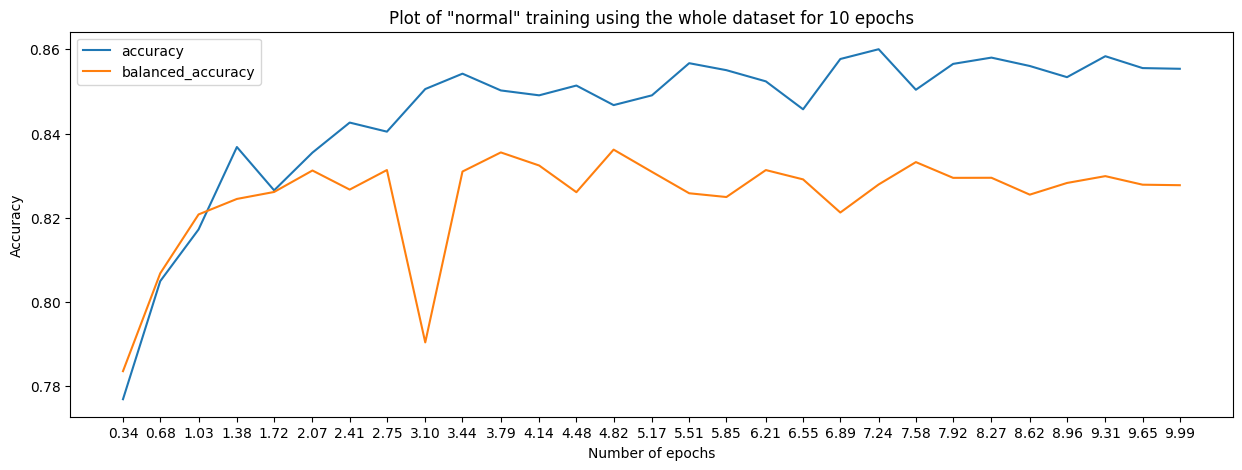

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("least_certain_200p8b1epo_newmodels.csv")
normal = pd.read_csv("normal_train_10epo100b8gas.csv")

fig = plt.figure(figsize=(15, 5))

plt.plot(normal['x_axis'], normal['accuracy'], label="accuracy")
plt.plot(normal['x_axis'], normal['balanced_accuracy'], label="balanced_accuracy")
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Plot of "normal" training using the whole dataset for 10 epochs')
plt.xticks(normal['x_axis'])
plt.legend()
plt.show()



# df = df.head(300)

# print(normal.max())

# normal_plot = normal[["accuracy", "balanced_accuracy"]]

# plot = normal_plot.plot(xticks=normal.x_axis)
# plot.set_xlabel("Number of samples (x200)")
# plot.set_ylabel("Accuracy")
# plot.plot()

[]

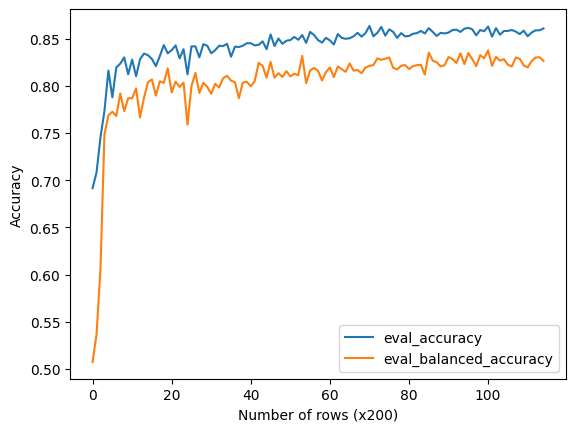

In [3]:
import pandas as pd
# df_entropy = pd.read_csv('entropy_100p_1epo_allrows.csv')
# df_least = pd.read_csv('least_certain_100p_1epo_allrows.csv')
# df_margin = pd.read_csv('margin_100p_1epo_allrows.csv')

df = pd.read_csv('ashdjjasikhd.csv')

df = df[["eval_accuracy", "eval_balanced_accuracy"]]


plot = df.plot()
plot.set_xlabel("Number of rows (x200)")
plot.set_ylabel("Accuracy")
plot.plot()

Index for when the model reaches its highest value:
random_iter           92
random_newmodels     106
entropy_iter          43
entropy_newmodels    103
LC_iter               39
LC_newmodels         105
margin_iter           50
margin_newmodels     101
dtype: int64

Max accuracy:
random_iter          0.851716
random_newmodels     0.870043
entropy_iter         0.858381
entropy_newmodels    0.866378
LC_iter              0.856048
LC_newmodels         0.866378
margin_iter          0.857048
margin_newmodels     0.866378
dtype: float64

Values for column=eval_accuracy at row=50:
random_iter          0.825058
random_newmodels     0.841719
entropy_iter         0.849384
entropy_newmodels    0.852716
LC_iter              0.852383
LC_newmodels         0.856048
margin_iter          0.857048
margin_newmodels     0.857714
Name: 50, dtype: float64

Total train time:
random_iter           1607.0949
random_newmodels     11312.1768
entropy_iter          1493.4389
entropy_newmodels    11166.0481
LC_iter  

C:\Users\Marcus\AppData\Local\Temp\ipykernel_17628\1234677834.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(new_tick_labels)


[]

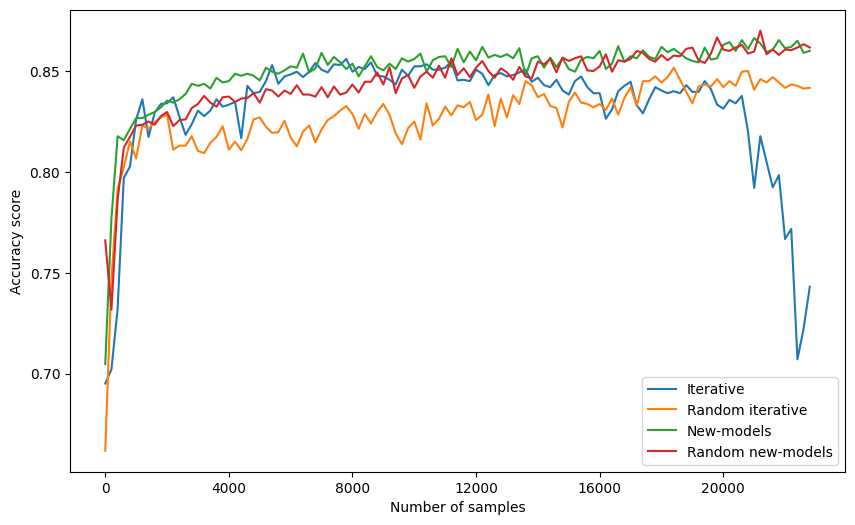

In [2]:
import pandas as pd

df_entropy_iter = pd.read_csv('entropyshannon_200p32b5epo_iter.csv')
df_entropy_newmodels = pd.read_csv('entropyshannon_200p32b5epo_newmodels.csv')
df_LC_iter = pd.read_csv('least_certain_200p32b5epo_iter.csv')
df_LC_newmodels = pd.read_csv('least_certain_200p32b5epo_newmodels.csv')
df_margin_iter = pd.read_csv('margin_200p32b5epo_iter.csv')
df_margin_newmodels = pd.read_csv('margin_200p32b5epo_newmodels.csv')

random_iter = pd.read_csv('random_200p32b5epo_iter_true.csv')

# simen_iter_1 = pd.read_csv('simen_iter_1.csv')
simen_new_1 = pd.read_csv('simen_new_1.csv')
simen_new_2 = pd.read_csv('simen_new_2.csv')
simen_new_3 = pd.read_csv('simen_new_3.csv')
simen_new_4 = pd.read_csv('simen_new_4.csv')

random_newmodel_1 = pd.read_csv('random_200p32b5epo_newmodels.csv')
random_newmodel_2 = pd.read_csv('random_200p32b5epo_newmodels_2.csv')
random_newmodel_3 = pd.read_csv('random_200p32b5epo_newmodels_3.csv')
random_newmodel_4 = pd.read_csv('random_200p32b5epo_newmodels_4.csv')
random_newmodel_5 = pd.read_csv('random_200p32b5epo_newmodels_5.csv')
random_newmodel_6 = pd.read_csv('random_200p32b5epo_newmodels_6.csv')
random_newmodel_7 = pd.read_csv('random_200p32b5epo_newmodels_7.csv')
random_newmodel_8 = pd.read_csv('random_200p32b5epo_newmodels_8.csv')

simen_iter_1 = pd.read_csv('random_200p32b5epo_iter_simen_1.csv')
simen_iter_2 = pd.read_csv('random_200p32b5epo_iter_simen_2.csv')
simen_iter_3 = pd.read_csv('random_200p32b5epo_iter_simen_3.csv')
simen_iter_4 = pd.read_csv('random_200p32b5epo_iter_simen_4.csv')
simen_iter_5 = pd.read_csv('random_200p32b5epo_iter_simen_5.csv')
simen_iter_6 = pd.read_csv('random_200p32b5epo_iter_simen_6.csv')
simen_iter_7 = pd.read_csv('random_200p32b5epo_iter_simen_7.csv')
simen_iter_8 = pd.read_csv('random_200p32b5epo_iter_simen_8.csv')
simen_iter_9 = pd.read_csv('random_200p32b5epo_iter_simen_9.csv')
simen_iter_10 = pd.read_csv('random_200p32b5epo_iter_simen_10.csv')
simen_iter_11 = pd.read_csv('random_200p32b5epo_iter_simen_11.csv')
simen_iter_12 = pd.read_csv('random_200p32b5epo_iter_simen_12.csv')

# set the index to match the interval of 10
# random_newmodel_7.index = range(0, len(random_newmodel_7)*10, 10)

# get the values of a particular column based on an interval of 10
# col1_values = random_newmodel_7['eval_f1_score'].iloc[::10].tolist()
# print(col1_values)

# Change the column shown:
column = "eval_accuracy"

# Columns:
# eval_runtime,eval_balanced_accuracy,epoch,eval_f1_score,eval_loss,eval_recall,eval_precision,eval_samples_per_second,
# eval_accuracy,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,train_loss

# Check values for specific index:
row_index = 50

concat_lc = pd.concat([df_LC_iter[column], simen_iter_2[column], df_LC_newmodels[column], random_newmodel_7[column]], axis=1)
concat_lc.columns = ["Iterative", "Random iterative", "New-models", "Random new-models"]


# All runs
concat_acc_all = pd.concat([simen_iter_2[column], random_newmodel_7[column], df_entropy_iter[column], df_entropy_newmodels[column], 
                            df_LC_iter[column], df_LC_newmodels[column], df_margin_iter[column], df_margin_newmodels[column]], axis=1)
concat_acc_all.columns = ["random_iter", "random_newmodels", "entropy_iter", "entropy_newmodels", "LC_iter", "LC_newmodels", "margin_iter", "margin_newmodels"]

# All iterative runs
concat_acc_iter = pd.concat([simen_iter_2[column], df_entropy_iter[column], df_LC_iter[column], df_margin_iter[column]], axis=1)
concat_acc_iter.columns = ["Random", "Entropy", "Least certain", "Smallest margin"]

# All newmodel runs
concat_acc_newmodels = pd.concat([random_newmodel_7[column], df_entropy_newmodels[column], df_LC_newmodels[column], df_margin_newmodels[column]], axis=1)
concat_acc_newmodels.columns = ["Random", "Entropy", "Least certain", "Smallest margin"]


# Dataframe for runtime for each iteration of training
concat_train_time = pd.concat([simen_iter_2["train_runtime"], random_newmodel_7["train_runtime"], df_entropy_iter["train_runtime"], df_entropy_newmodels["train_runtime"], 
                               df_LC_iter["train_runtime"], df_LC_newmodels["train_runtime"], df_margin_iter["train_runtime"], df_margin_newmodels["train_runtime"]], axis=1)
concat_train_time.columns = ["random_iter", "random_newmodels", "entropy_iter", "entropy_newmodels", "LC_iter", "LC_newmodels", "margin_iter", "margin_newmodels"]

# Dataframe for cumulative runtime sum
cumulative_sum = concat_train_time.cumsum(axis=0)
cumsum_df = pd.DataFrame(cumulative_sum, columns=concat_train_time.columns)

max_index = concat_acc_all.idxmax(axis=0)
print("Index for when the model reaches its highest value:")
print(max_index)

print()
print("Max accuracy:")
print(concat_acc_all.max())

row_values = concat_acc_all.loc[row_index]
print()
print(f"Values for column={column} at row={row_index}:")
print(row_values)

time_df = concat_train_time.sum()
print()
print("Total train time:")
print(time_df)


# Change dataframe to plot here
plot = concat_lc.plot(figsize=(10, 6))

ticks = plot.get_xticklabels()
new_ticks = ticks[1:]
new_tick_labels = [int(label.get_text()) * 200 for label in new_ticks]
new_tick_labels = [''] + new_tick_labels
plot.set_xticklabels(new_tick_labels)

# Change axes-titles here
plot.set_xlabel("Number of samples")
plot.set_ylabel("Accuracy score")

plot.plot()